In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copia
from tqdm import tqdm
import bambi as bmb
import arviz as az

In [37]:
#df_2 = pd.read_csv('data/number_of_works_individuals.csv')
df = pd.read_csv('data/df_indi_works.csv', index_col = [0])
df.sample(5)

print(len(set(df.individual_wikidata_id)))

159745


In [38]:
df['region_name'].value_counts()

Western Europe         131435
Northwestern Europe    104911
German world            41581
Germany                 31402
Southwestern Europe     26524
France                  25293
Eastern Europe          20349
Italy                   18494
British Islands         17693
United Kingdom          16930
Northern France         15693
Northern Italy          13385
Low countries           12026
Central Europe          11789
Nordic countries         8243
Netherlands              7728
Spain                    6982
Austria                  6710
Slav world               5398
Southern France          5298
Belgium                  4296
Sweden                   3847
Southern Italy           3732
Switzerland              3473
Denmark                  2699
Ottoman world            2311
Muslim world             2245
Chinese world            2211
mediterranean World      1783
Japan                    1709
Arabic world             1692
Balkans                  1664
Greek World              1525
Portugal  

In [39]:
df['count_works'] = [i if i > 0 else 1 for i in df['count_works']]

Lots of writers with 0 works: ignore them? Or one-smoothing?

In [40]:
print(len(df))
df = df[df['count_works'] > 0]
print(len(df))
df.sample(5)

570466
570466


,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works
416545,Q64294,1829.0,1864.0,1860,Ferdinand von Hochstetter,re_german_world,German world,2.0
217255,Q6698176,1797.0,1832.0,1830,Lucy Anderson,re_british_islands,British Islands,1.0
303008,Q94871948,1575.0,1610.0,1610,Philipp Ludwig Piscator,re_ottoman_world,Ottoman world,1.0
552777,Q15488419,1662.0,1697.0,1700,Domingo Echevarría,re_spain,Spain,1.0
308527,Q4894310,1642.0,1677.0,1680,Josep Romaguera,re_spain,Spain,2.0


In [41]:
region_df = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
region_df = region_df[region_df['level'] == 2]
regions = set(region_df['region_name'])
print(regions)

{'Greek World', 'Korea', 'Italy', 'United Kingdom', 'Nordic countries', 'Chinese world', 'German world', 'Portugal', 'Arabic world', 'Central Europe', 'Japan', 'Latin World', 'Eastern Europe', 'Persian world', 'Slav world', 'Low countries', 'Indian world', 'France', 'Balkans', 'Spain'}


In [42]:
print(len(df))
df = df[df['region_name'].isin(regions)]
print(len(df))

570466
178901


count    178901.000000
mean       1705.014108
std         285.263790
min        -850.000000
25%        1689.000000
50%        1792.000000
75%        1827.000000
max        1850.000000
Name: birthyear, dtype: float64


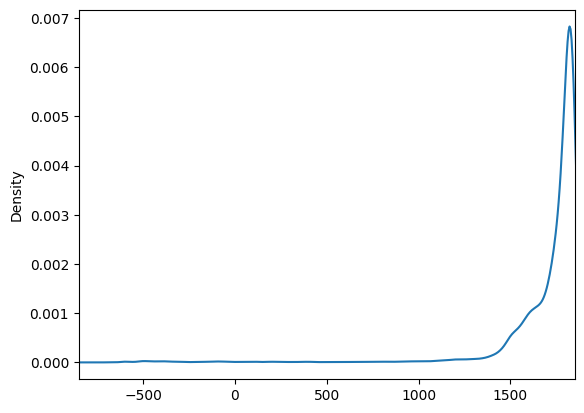

In [43]:
print(df['birthyear'].describe())
df['birthyear'].plot.kde()
plt.xlim(df['birthyear'].min(), df['birthyear'].max());

In [44]:
# productive_year ?

count    178901.000000
mean       1705.014108
std         285.263790
min        -850.000000
25%        1689.000000
50%        1792.000000
75%        1827.000000
max        1850.000000
Name: birthyear, dtype: float64


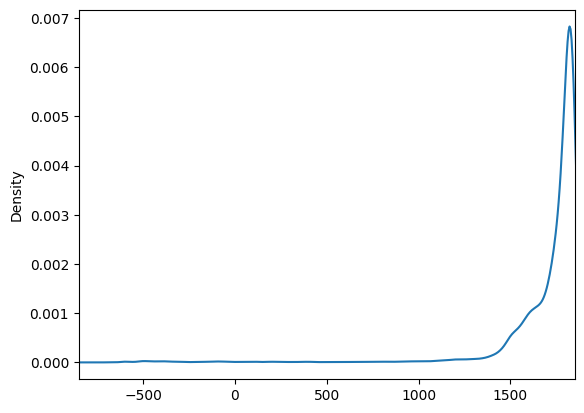

In [45]:
print(df['birthyear'].describe())
df['birthyear'].plot.kde()
plt.xlim(df['birthyear'].min(), df['birthyear'].max());

In [46]:
temporal_cnts = []
window = 50
for year in range(int(df['birthyear'].min() + window), int(df['birthyear'].max() - window + 1)):
    y1, y2 = year - window, year + window
    d = df[(df['birthyear'] >= y1) & (df['birthyear'] <= y2)]
    S_obs = len(d)
    N = sum(d['count_works'])
    #div = copia.diversity(d['count_works'], method='chao1', CI=True, n_iter=100)
    div = copia.diversity(d['count_works'], method='chao1')
    ch1 = div
    #ch1 = div['richness']
    #ch1_lci = div['lci']
    #ch1_uci = div['uci']
    cnts = np.array(d['count_works'].astype(int))
    #temporal_cnts.append((year, S_obs, N, ch1, ch1_lci, ch1_uci))
    temporal_cnts.append((year, S_obs, N, ch1))
#temporal_cnts = pd.DataFrame(temporal_cnts, columns=['year', 'S', 'N', 'chao1', 'chao1_lci', 'chao1_uci'])
temporal_cnts = pd.DataFrame(temporal_cnts, columns=['year', 'S', 'N', 'chao1'])
temporal_cnts.sample(5)

,year,S,N,chao1
1632,832,253,8587.0,1162.921800
981,181,219,807.0,818.282789
617,-183,219,562.0,1386.953800
1184,384,220,1025.0,819.440924
2098,1298,1199,9409.0,8162.110620


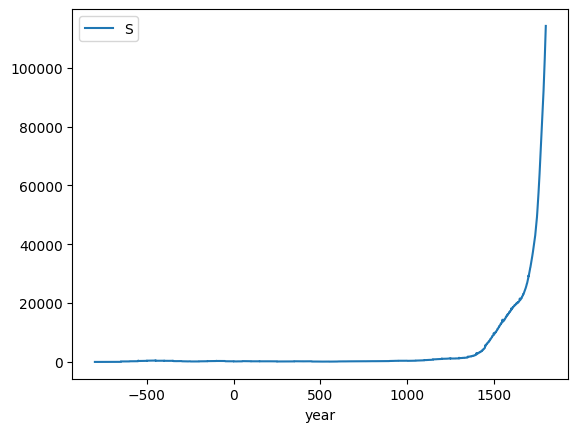

In [47]:
temporal_cnts.plot('year', 'S');

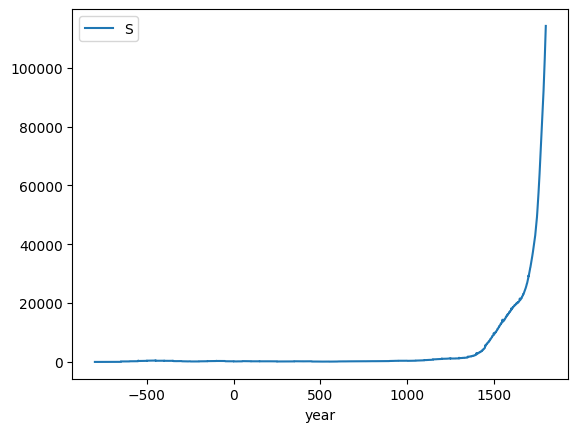

In [48]:
temporal_cnts.plot('year', 'S');

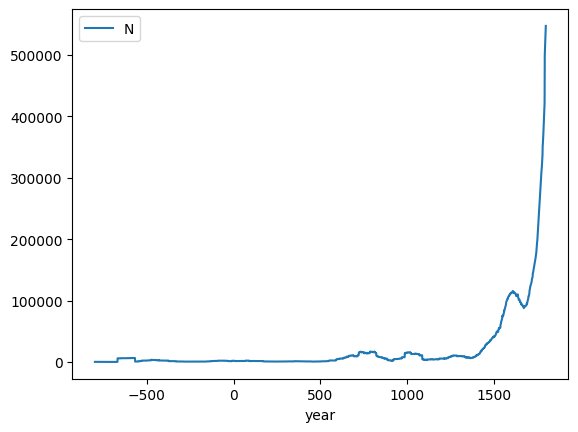

In [49]:
temporal_cnts.plot('year', 'N');

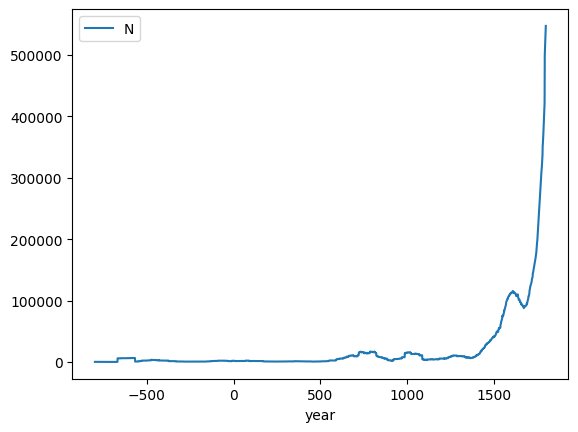

In [50]:
temporal_cnts.plot('year', 'N');

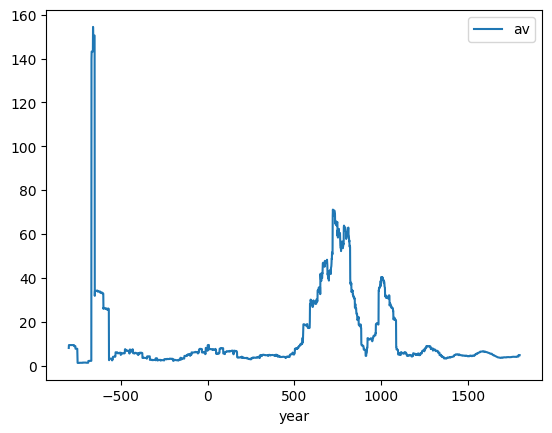

In [51]:
temporal_cnts['av'] = temporal_cnts['N'] / temporal_cnts['S']
temporal_cnts.plot('year', 'av');

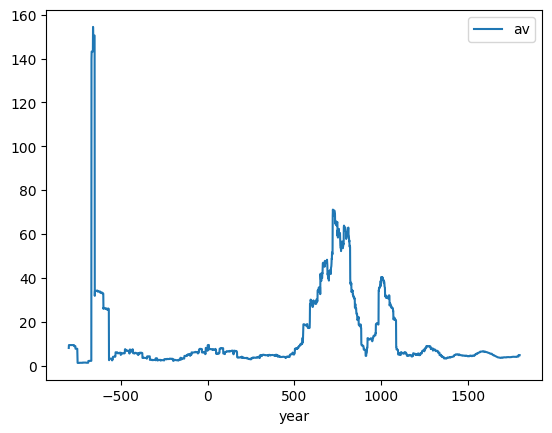

In [52]:
temporal_cnts['av'] = temporal_cnts['N'] / temporal_cnts['S']
temporal_cnts.plot('year', 'av');

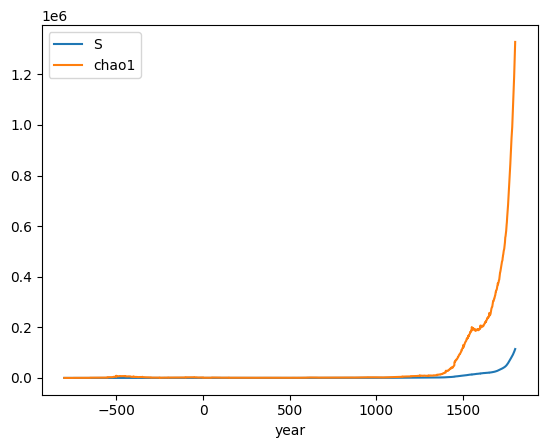

In [53]:
ax = temporal_cnts.plot('year', 'S');
temporal_cnts.plot('year', 'chao1', ax=ax);

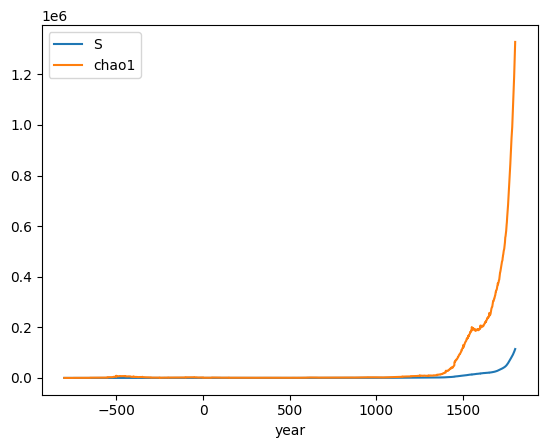

In [54]:
ax = temporal_cnts.plot('year', 'S');
temporal_cnts.plot('year', 'chao1', ax=ax);

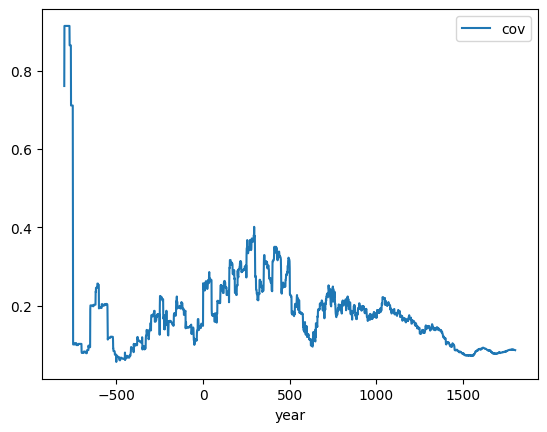

In [55]:
temporal_cnts['cov'] = temporal_cnts['S'] / temporal_cnts['chao1']
#temporal_cnts['cov_lci'] = temporal_cnts['S'] / temporal_cnts['chao1_lci']
#temporal_cnts['cov_uci'] = temporal_cnts['S'] / temporal_cnts['chao1_uci']

ax = temporal_cnts.plot('year', 'cov');
#temporal_cnts.plot('year', 'cov_lci', ax=ax, c='grey');
#temporal_cnts.plot('year', 'cov_uci', ax=ax, c='grey');
#ax.fill_between(temporal_cnts['year'], temporal_cnts['cov_lci'], temporal_cnts['cov_uci'], color='lightblue');

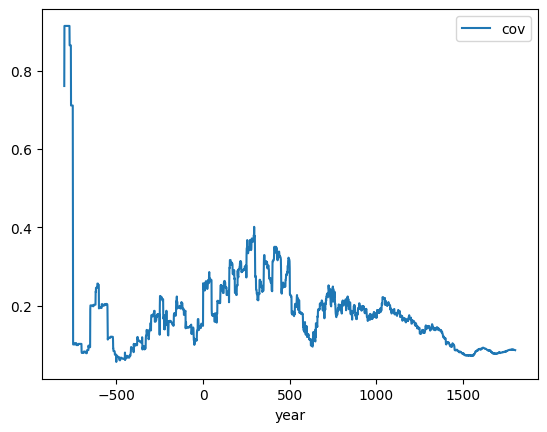

In [56]:
temporal_cnts['cov'] = temporal_cnts['S'] / temporal_cnts['chao1']
#temporal_cnts['cov_lci'] = temporal_cnts['S'] / temporal_cnts['chao1_lci']
#temporal_cnts['cov_uci'] = temporal_cnts['S'] / temporal_cnts['chao1_uci']

ax = temporal_cnts.plot('year', 'cov');
#temporal_cnts.plot('year', 'cov_lci', ax=ax, c='grey');
#temporal_cnts.plot('year', 'cov_uci', ax=ax, c='grey');
#ax.fill_between(temporal_cnts['year'], temporal_cnts['cov_lci'], temporal_cnts['cov_uci'], color='lightblue');

In [58]:
region_df = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
region_df = region_df[region_df['level'] == 2]
regions = set(region_df['region_name'])
print(regions)

{'Greek World', 'Korea', 'Italy', 'United Kingdom', 'Nordic countries', 'Chinese world', 'German world', 'Portugal', 'Arabic world', 'Central Europe', 'Japan', 'Latin World', 'Eastern Europe', 'Persian world', 'Slav world', 'Low countries', 'Indian world', 'France', 'Balkans', 'Spain'}


## Generalized Chao

In [59]:
print(len(df))
df = df[df['region_name'].isin(regions)]
print(len(df))

178901
178901


In [60]:
from sklearn.preprocessing import StandardScaler
date_scaler = StandardScaler()
df['date'] = date_scaler.fit_transform(np.array(df['birthyear']).reshape(-1, 1)) # What does it mean to do that?
df['region'] = df['region_name'].astype('category')
df.head()

,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works,date,region
2,Q202809,1803.0,1838.0,1840,Frederick Coombs,re_united_kingdom,United Kingdom,1.0,0.343493,United Kingdom
4,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_eastern_europe,Eastern Europe,1.0,0.280394,Eastern Europe
5,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_slav_world,Slav world,1.0,0.280394,Slav world
8,Q1028749,1683.0,1718.0,1720,Christian Friedrich Zincke,re_united_kingdom,United Kingdom,22.0,-0.077171,United Kingdom
12,Q2822993,1100.0,1135.0,1140,Achard of Saint-Victor,re_united_kingdom,United Kingdom,1.0,-2.120899,United Kingdom


In [61]:
df['count'] = df['count_works'].astype(int)
df = df[df['count'].isin({1, 2})]
df.head()

,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works,date,region,count
2,Q202809,1803.0,1838.0,1840,Frederick Coombs,re_united_kingdom,United Kingdom,1.0,0.343493,United Kingdom,1
4,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_eastern_europe,Eastern Europe,1.0,0.280394,Eastern Europe,1
5,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_slav_world,Slav world,1.0,0.280394,Slav world,1
12,Q2822993,1100.0,1135.0,1140,Achard of Saint-Victor,re_united_kingdom,United Kingdom,1.0,-2.120899,United Kingdom,1
16,Q105607234,1787.0,1822.0,1820,Angelo Dalbon,re_italy,Italy,1.0,0.287405,Italy,1


In [62]:
df['y'] = df['count'].map({1: 0, 2: 1})
df

,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works,date,region,count,y
2,Q202809,1803.0,1838.0,1840,Frederick Coombs,re_united_kingdom,United Kingdom,1.0,0.343493,United Kingdom,1,0
4,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_eastern_europe,Eastern Europe,1.0,0.280394,Eastern Europe,1,0
5,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_slav_world,Slav world,1.0,0.280394,Slav world,1,0
12,Q2822993,1100.0,1135.0,1140,Achard of Saint-Victor,re_united_kingdom,United Kingdom,1.0,-2.120899,United Kingdom,1,0
16,Q105607234,1787.0,1822.0,1820,Angelo Dalbon,re_italy,Italy,1.0,0.287405,Italy,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
570455,Q5549197,1837.0,1872.0,1870,Michael Anagnos,re_eastern_europe,Eastern Europe,1.0,0.462681,Eastern Europe,1,0
570459,Q55191347,1732.0,1767.0,1770,Jean-Baptiste Daubanton,re_france,France,1.0,0.094600,France,1,0
570461,Q43136014,1844.0,1879.0,1880,Alexandre Nicolaievich Roussoff,re_eastern_europe,Eastern Europe,1.0,0.487220,Eastern Europe,1,0
570462,Q43136014,1844.0,1879.0,1880,Alexandre Nicolaievich Roussoff,re_slav_world,Slav world,1.0,0.487220,Slav world,1,0


In [63]:
#df = df.sample(100000)

In [64]:
df['y'].value_counts(dropna=False)

0    151623
1      6202
Name: y, dtype: int64

In [65]:
df['date'].describe()

count    157825.000000
mean          0.012662
std           0.978314
min          -8.956697
25%          -0.038610
50%           0.308438
75%           0.427626
max           0.508253
Name: date, dtype: float64

In [66]:
intercept_model = bmb.Model('y ~ 1', df, family='bernoulli')
intercept_fit = intercept_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(intercept_fit)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.196,0.013,-3.221,-3.173,0.0,0.0,1956.0,2668.0,1.0


In [67]:
date_model = bmb.Model('y ~ date', df, family='bernoulli')
date_fit = date_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.plot_forest(date_fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--')

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, date]


EOFError: 

In [ ]:
az.summary(date_fit)

In [ ]:
region_model = bmb.Model('y ~ region', df, family='bernoulli')
region_fit = region_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(region_fit)

In [ ]:
az.plot_forest(region_fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

In [ ]:
covariate_model = bmb.Model('y ~ region + date', df, family='bernoulli')
covariate_fit = covariate_model.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(covariate_fit)
az.plot_forest(covariate_fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

In [ ]:
region_model_vi = bmb.Model('y ~ (1|region)', df, family='bernoulli')
region_fit_vi = region_model_vi.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(region_fit_vi)

In [ ]:
models_dict = {
    "date": date_fit,
    "region": region_fit,
    "region_vi": region_fit_vi,
#     "covariate": covariate_fit,
     "intercept": intercept_fit
}

# loo_compare = az.compare(models_dict, ic='LOO')
waic_compare = az.compare(models_dict, ic='WAIC')

In [ ]:
az.plot_compare(waic_compare, insample_dev=True);

In [ ]:
waic_compare

In [ ]:
df_compare = pd.concat([loo_compare, waic_compare], axis=1)
df_compare

In [ ]:
DATE = np.linspace(int(df['birthyear'].min()), int(df['birthyear'].max()))
DATE_SCALED = date_scaler.transform(DATE.reshape(-1, 1)).flatten()

In [ ]:
fig, ax = plt.subplots()
handles = []
i = 0

new_data = pd.DataFrame({
            "date": DATE_SCALED,
        })
new_idata = date_model.predict(date_fit, data=new_data, inplace=False)
mean = new_idata.posterior["y_mean"].values

az.plot_hdi(DATE, mean, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel(f"P($f_2$)")
ax.legend(handles=handles, loc="upper left");